# Setup

## Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import os
import re
import joblib

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kmodes.kprototypes import KPrototypes
from gap_statistic import OptimalK

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
    homogeneity_completeness_v_measure,
    fowlkes_mallows_score,
    classification_report,
    roc_auc_score
)

from sklearn import tree


## Global Configuration

In [13]:
INPUT_DIR = '../data/input/'
INPUT_PATH = f'{INPUT_DIR}german_data.csv'
OUTPUT_DIR = INPUT_DIR

EDA_DIR = '../data/EDA/'

FEATURE_INPUT_DIR = '../data/feature/step2/'
PIPELINE_INPUT_DIR = '../data/pipeline/step2/'

FEATURE_OUTPUT_DIR = '../data/feature/step3/'
PIPELINE_OUTPUT_DIR = '../data/pipeline/step3/'

FEATURE_TRAIN_PATH = '../data/feature/step1/02_pipeline_smote_train.csv'
FEATURE_TEST_PATH = '../data/feature/step1/02_pipeline_smote_test.csv'
ENC_TRAIN_PATH = '../data/feature/step1/03_pipeline_rare_freq_train.csv'
ENC_TEST_PATH = '../data/feature/step1/03_pipeline_rare_freq_test.csv'

OUTPUT = False
SEED = 888

In [3]:
if not os.path.exists(FEATURE_OUTPUT_DIR):
    os.makedirs(FEATURE_OUTPUT_DIR)
    
if not os.path.exists(PIPELINE_OUTPUT_DIR):
    os.makedirs(PIPELINE_OUTPUT_DIR)

In [4]:
pd.options.display.max_columns = None

In [5]:
COLOR_MAP = {0: '#00BFC4', 1: '#F8766D'}

## Global Function

In [6]:
def kmeans_optimalK(data, K):
    model = KMeans(random_state=SEED, max_iter=300)
    model.fit(data)
    return model.cluster_centers_, model.predict(data)

# Data

We decided to take rare encoding + frequency encoding -> pca pipeline due to the reason that they have obvious clustering patterns over their PC plots. From the PC components plot, we can somehow decide that thre will be 2-4 clusters, but we can still use other methods to judge whether if which k will be optimal.

In [14]:
df_train = pd.read_csv(FEATURE_TRAIN_PATH)
df_test = pd.read_csv(FEATURE_TEST_PATH)

df_train_enc = pd.read_csv(ENC_TRAIN_PATH)
df_test_enc = pd.read_csv(ENC_TEST_PATH)

X_train = df_train.drop('label', axis=1)
y_train = df_train.label

X_test = df_test.drop('label', axis=1)
y_test = df_test.label

X_train_enc = df_train_enc.drop('label', axis=1)
X_test_enc = df_test_enc.drop('label', axis=1)

In [8]:
display(
    df_train.shape,
    df_test.shape,
#     X_train_pca.shape,
#     X_test_pca.shape,
    X_train.shape,
    X_test.shape
)

(978, 21)

(300, 21)

(978, 20)

(300, 20)

# K Prototype Clustering

In [9]:
categorical_cols = X_train.select_dtypes(object).columns.tolist()
categorical_cols_boolean = [col in categorical_cols for col in X_train.columns]
categorical_cols_index = [i for i,x in enumerate(categorical_cols_boolean) if x]
print(categorical_cols_index)

[0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18]


## Elbow Method

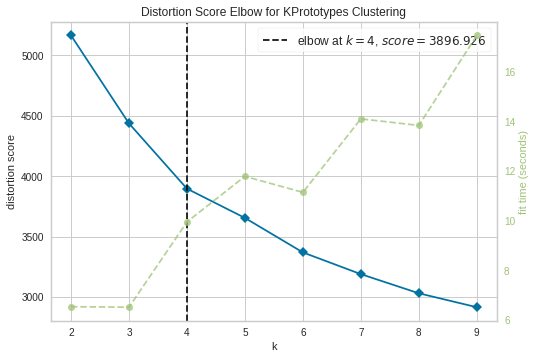

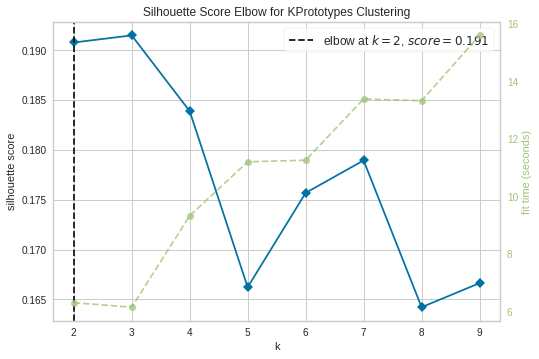

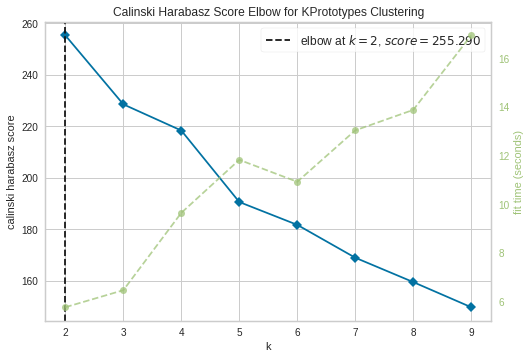

In [16]:
n_cluster_range = (2, 10)
metric_list = [
    'distortion',
    'silhouette',
    'calinski_harabasz'
]

model = KPrototypes(
    random_state=SEED,
    n_jobs=-1,
)

optimal_k_set = set()

for metric in metric_list:
    visualizer = KElbowVisualizer(
        model, 
        k=n_cluster_range,
        timings=True,
        metric=metric
    )
    visualizer.fit(X_train_enc, categorical=categorical_cols_index)
    visualizer.show()
    optimal_k_set.add(visualizer.elbow_value_)
    plt.show()

In [17]:
optimal_k_set

{2, 4}

## Intercluster Distance

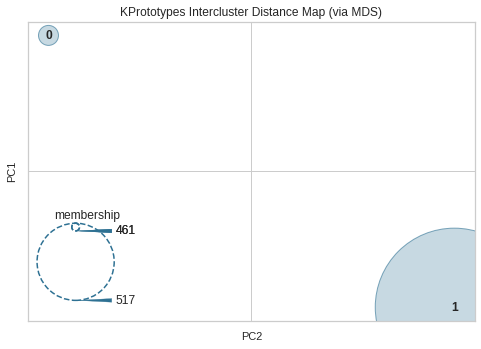

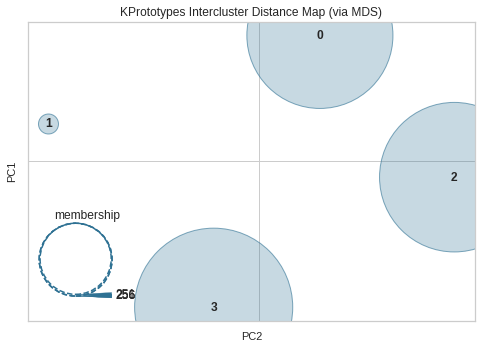

In [31]:
for i in optimal_k_set:
    model = KPrototypes(
        random_state=SEED,
        n_jobs=-1,
        n_clusters=i
    )
    model.fit(X_train_enc, categorical=categorical_cols_index)
    model.cluster_centers_ = model.cluster_centroids_
    visualizer = InterclusterDistance(model)
    visualizer.fit(X_train_enc)
    visualizer.show()

# Feature Selection

As suggested by PCA loadings, we knew that 
- for categorical variables appear at least 4 times in top 3 highest / lowest loadings within each PC
    - credit_history
    - saving_accounts_or_bonds
    - other_installment_plans
    - housing
    - job
- for numerical variables appear at least 4 times in top 3 highest / lowest loading within each PC
    - duration_mth
    - installment_rate_percent
    - present_residence_since
    - monthly_affordability_amount

However, since our focus is to do a clustering over categorical variables to increase the explainability.

In [33]:
pca_suggested_categorical_features = [
    'credit_history', 
    'saving_accounts_or_bonds',
    'other_installment_plans',
    'housing',
    'job'
]

pca_suggested_numerical_features = [
    'duration_mth',
    'installment_rate_percent',
    'present_residence_since',
    'monthly_affordability_amount'
]

# Model Selection (KMeans)

In [37]:
selected_features = pca_suggested_categorical_features + pca_suggested_numerical_features

In [38]:
selected_features

['credit_history',
 'saving_accounts_or_bonds',
 'other_installment_plans',
 'housing',
 'job',
 'duration_mth',
 'installment_rate_percent',
 'present_residence_since',
 'monthly_affordability_amount']

## All

In [49]:
X_train1 = X_train.loc[:, selected_features]
X_test1 = X_test.loc[:, selected_features]

In [45]:
categorical_cols = X_train1.select_dtypes(object).columns.tolist()
categorical_cols_boolean = [col in categorical_cols for col in X_train1.columns]
categorical_cols_index = [i for i,x in enumerate(categorical_cols_boolean) if x]
print(categorical_cols_index)

[0, 1, 2, 3, 4]


### K=2

In [50]:
model = KPrototypes(
    random_state=SEED,
    n_jobs=-1,
    n_clusters=2
)

model.fit(X_train1, categorical=categorical_cols_index)

y_pred_train = pd.Series(model.predict(X_train1, categorical=categorical_cols_index), 
                         name='cluster')
y_pred_test = pd.Series(model.predict(X_test1, categorical=categorical_cols_index), 
                        name='cluster')

y_eval_train = pd.concat([y_train, y_pred_train], axis=1)
y_eval_test = pd.concat([y_test, y_pred_test], axis=1)

In [51]:
display(
    y_eval_train.cluster.value_counts(),
    y_eval_train.groupby('cluster').label.value_counts(normalize=True)
)

0    520
1    458
Name: cluster, dtype: int64

cluster  label
0        1        0.548077
         0        0.451923
1        0        0.554585
         1        0.445415
Name: label, dtype: float64

In [52]:
display(
    y_eval_test.cluster.value_counts(),
    y_eval_test.groupby('cluster').label.value_counts(normalize=True)
)

0    163
1    137
Name: cluster, dtype: int64

cluster  label
0        0        0.693252
         1        0.306748
1        0        0.715328
         1        0.284672
Name: label, dtype: float64

- cluster 0: Good Payer
- cluster 1: Bad Payer

### K=4

In [54]:
model = KPrototypes(
    random_state=SEED,
    n_jobs=-1,
    n_clusters=4
)

model.fit(X_train1, categorical=categorical_cols_index)

y_pred_train = pd.Series(model.predict(X_train1, categorical=categorical_cols_index), 
                         name='cluster')
y_pred_test = pd.Series(model.predict(X_test1, categorical=categorical_cols_index), 
                        name='cluster')

y_eval_train = pd.concat([y_train, y_pred_train], axis=1)
y_eval_test = pd.concat([y_test, y_pred_test], axis=1)

In [55]:
display(
    y_eval_train.cluster.value_counts(),
    y_eval_train.groupby('cluster').label.value_counts(normalize=True)
)

0    293
2    248
1    230
3    207
Name: cluster, dtype: int64

cluster  label
0        1        0.532423
         0        0.467577
1        1        0.695652
         0        0.304348
2        0        0.741935
         1        0.258065
3        1        0.526570
         0        0.473430
Name: label, dtype: float64

In [56]:
display(
    y_eval_test.cluster.value_counts(),
    y_eval_test.groupby('cluster').label.value_counts(normalize=True)
)

2    96
3    77
0    74
1    53
Name: cluster, dtype: int64

cluster  label
0        0        0.702703
         1        0.297297
1        0        0.641509
         1        0.358491
2        0        0.760417
         1        0.239583
3        0        0.675325
         1        0.324675
Name: label, dtype: float64

Train Data Set
- Cluster 0, 1, 3: bad payer
- Cluster 2: bad payer

Test Data Set
- Cluster 0, 1, 2, 3 are good payer

Finalize to use k = 3 for categorical variables

## Cluster Analysis

In [96]:
model = KPrototypes(
    random_state=SEED,
    n_jobs=-1,
    n_clusters=4
)

model.fit(X_train1, categorical=categorical_cols_index)

y_pred_train = pd.Series(model.predict(X_train1, categorical=categorical_cols_index), 
                         name='cluster')
y_pred_test = pd.Series(model.predict(X_test1, categorical=categorical_cols_index), 
                        name='cluster')

In [97]:
df_train_analysis = pd.concat([df_train, y_pred_train], axis=1)
df_test_analysis = pd.concat([df_test, y_pred_test], axis=1)

In [104]:
for cluster in sorted(y_pred_train.unique()):
    mask = df_train_analysis.cluster == cluster
    print('\n')
    print(f'Cluster {cluster}: {mask.sum()}')
    display(
        df_train_analysis.loc[mask, :].describe(include='all')[pca_suggested_categorical_features+pca_suggested_numerical_features],
    )



Cluster 0: 293


,credit_history,saving_accounts_or_bonds,other_installment_plans,housing,job,duration_mth,installment_rate_percent,present_residence_since,monthly_affordability_amount
count,293,293,293,293,293,293.000000,293.000000,293.000000,293.000000
unique,5,5,3,3,4,NaN,NaN,NaN,NaN
top,A32,A61,A143,A152,A173,NaN,NaN,NaN,NaN
freq,211,223,260,266,222,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,-0.105095,3.805461,1.825939,-0.206163
std,NaN,NaN,NaN,NaN,NaN,0.766983,0.413436,0.422496,0.789574
min,NaN,NaN,NaN,NaN,NaN,-1.865220,2.000000,1.000000,-2.813235
25%,NaN,NaN,NaN,NaN,NaN,-0.671355,4.000000,2.000000,-0.729960
50%,NaN,NaN,NaN,NaN,NaN,-0.093450,4.000000,2.000000,-0.188655
75%,NaN,NaN,NaN,NaN,NaN,0.522509,4.000000,2.000000,0.277823




Cluster 1: 230


,credit_history,saving_accounts_or_bonds,other_installment_plans,housing,job,duration_mth,installment_rate_percent,present_residence_since,monthly_affordability_amount
count,230,230,230,230,230,230.000000,230.000000,230.00000,230.000000
unique,5,5,3,3,4,NaN,NaN,NaN,NaN
top,A32,A61,A143,A152,A173,NaN,NaN,NaN,NaN
freq,165,179,210,177,184,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.931473,3.752174,3.83913,0.631522
std,NaN,NaN,NaN,NaN,NaN,0.645785,0.532252,0.48130,0.756763
min,NaN,NaN,NaN,NaN,NaN,-1.819211,2.000000,2.00000,-0.620362
25%,NaN,NaN,NaN,NaN,NaN,0.522509,4.000000,4.00000,0.065506
50%,NaN,NaN,NaN,NaN,NaN,0.922890,4.000000,4.00000,0.540777
75%,NaN,NaN,NaN,NaN,NaN,1.454626,4.000000,4.00000,1.094994




Cluster 2: 248


,credit_history,saving_accounts_or_bonds,other_installment_plans,housing,job,duration_mth,installment_rate_percent,present_residence_since,monthly_affordability_amount
count,248,248,248,248,248,248.000000,248.000000,248.000000,248.000000
unique,5,5,3,3,4,NaN,NaN,NaN,NaN
top,A32,A61,A143,A152,A173,NaN,NaN,NaN,NaN
freq,129,152,207,174,151,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,-0.257118,1.629032,2.693548,0.326787
std,NaN,NaN,NaN,NaN,NaN,1.100156,0.500490,1.117961,0.936065
min,NaN,NaN,NaN,NaN,NaN,-2.563586,1.000000,1.000000,-2.625385
25%,NaN,NaN,NaN,NaN,NaN,-0.985383,1.000000,2.000000,-0.259741
50%,NaN,NaN,NaN,NaN,NaN,-0.287017,2.000000,3.000000,0.272498
75%,NaN,NaN,NaN,NaN,NaN,0.522509,2.000000,4.000000,0.884504




Cluster 3: 207


,credit_history,saving_accounts_or_bonds,other_installment_plans,housing,job,duration_mth,installment_rate_percent,present_residence_since,monthly_affordability_amount
count,207,207,207,207,207,207.000000,207.000000,207.000000,207.000000
unique,5,5,3,3,4,NaN,NaN,NaN,NaN
top,A32,A61,A143,A152,A173,NaN,NaN,NaN,NaN
freq,138,148,181,163,160,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,-0.194967,3.879227,3.845411,-0.881259
std,NaN,NaN,NaN,NaN,NaN,0.693773,0.368549,0.362389,0.613097
min,NaN,NaN,NaN,NaN,NaN,-1.865220,2.000000,3.000000,-2.817465
25%,NaN,NaN,NaN,NaN,NaN,-0.671355,4.000000,4.000000,-1.239004
50%,NaN,NaN,NaN,NaN,NaN,-0.064440,4.000000,4.000000,-0.875525
75%,NaN,NaN,NaN,NaN,NaN,0.427851,4.000000,4.000000,-0.449454
